In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
import time

from tensorflow import keras

In [2]:
class_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck',
]

train_lables_file = "D:/project/dataset/cifar10/trainLabels.csv"
test_csv_file = "D:/project/dataset/cifar10/sampleSubmission.csv"
train_folder = "D:/project/dataset/cifar10/train/"
test_folder = "D:/project/dataset/cifar10/test/"

def parse_csv_file(filepath, folder):
    """Parses csv files into (filename(path), label) format"""
    results = []
    with open(filepath, 'r') as f:
        lines = f.readlines()[1:]
    for line in lines:
        image_id, label_str = line.strip('\n').split(',')
        image_full_path = os.path.join(folder, image_id + '.png')
        results.append((image_full_path, label_str))
    return results

train_labels_info = parse_csv_file(train_lables_file, train_folder)
test_csv_info = parse_csv_file(test_csv_file, test_folder)

import pprint
pprint.pprint(train_labels_info[0:5])
pprint.pprint(test_csv_info[0:5])
print(len(train_labels_info), len(test_csv_info))

[('D:/project/dataset/cifar10/train/1.png', 'frog'),
 ('D:/project/dataset/cifar10/train/2.png', 'truck'),
 ('D:/project/dataset/cifar10/train/3.png', 'truck'),
 ('D:/project/dataset/cifar10/train/4.png', 'deer'),
 ('D:/project/dataset/cifar10/train/5.png', 'automobile')]
[('D:/project/dataset/cifar10/test/1.png', 'cat'),
 ('D:/project/dataset/cifar10/test/2.png', 'cat'),
 ('D:/project/dataset/cifar10/test/3.png', 'cat'),
 ('D:/project/dataset/cifar10/test/4.png', 'cat'),
 ('D:/project/dataset/cifar10/test/5.png', 'cat')]
50000 300000


In [3]:
# train_df = pd.DataFrame(train_labels_info)
train_df = pd.DataFrame(train_labels_info[0:45000])
valid_df = pd.DataFrame(train_labels_info[45000:])
test_df = pd.DataFrame(test_csv_info)

train_df.columns = ['filepath', 'class']
valid_df.columns = ['filepath', 'class']
test_df.columns = ['filepath', 'class']

print(train_df.head())
print(valid_df.head())
print(test_df.head())

                                 filepath       class
0  D:/project/dataset/cifar10/train/1.png        frog
1  D:/project/dataset/cifar10/train/2.png       truck
2  D:/project/dataset/cifar10/train/3.png       truck
3  D:/project/dataset/cifar10/train/4.png        deer
4  D:/project/dataset/cifar10/train/5.png  automobile
                                     filepath       class
0  D:/project/dataset/cifar10/train/45001.png       horse
1  D:/project/dataset/cifar10/train/45002.png  automobile
2  D:/project/dataset/cifar10/train/45003.png        deer
3  D:/project/dataset/cifar10/train/45004.png  automobile
4  D:/project/dataset/cifar10/train/45005.png    airplane
                                filepath class
0  D:/project/dataset/cifar10/test/1.png   cat
1  D:/project/dataset/cifar10/test/2.png   cat
2  D:/project/dataset/cifar10/test/3.png   cat
3  D:/project/dataset/cifar10/test/4.png   cat
4  D:/project/dataset/cifar10/test/5.png   cat


In [4]:
height = 32
width = 32
channels = 3
batch_size = 32
num_classes = 10

train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest',
)
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory = "D:/project/dataset/cifar10/output/",
    x_col = 'filepath',
    y_col = 'class',
    classes = class_names,
    target_size = (height, width),
    batch_size = batch_size,
    seed = 7,
    shuffle = True,
    class_mode = 'sparse',
)

valid_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255)
valid_generator = valid_datagen.flow_from_dataframe(
    valid_df,
    directory = "D:/project/dataset/cifar10/output/",
    x_col = 'filepath',
    y_col = 'class',
    classes = class_names,
    target_size = (height, width),
    batch_size = batch_size,
    seed = 7,
    shuffle = False,
    class_mode = "sparse")

train_num = train_generator.samples
valid_num = valid_generator.samples
print(train_num, valid_num)

Found 45000 validated image filenames belonging to 10 classes.
Found 5000 validated image filenames belonging to 10 classes.
45000 5000


In [5]:
for i in range(2):
    x, y = train_generator.next()
    print(x.shape, y.shape)
    print(y)

(32, 32, 32, 3) (32,)
[2. 1. 4. 4. 4. 4. 6. 5. 2. 8. 4. 6. 6. 3. 7. 1. 7. 2. 8. 8. 3. 0. 5. 3.
 9. 1. 4. 5. 6. 7. 9. 2.]
(32, 32, 32, 3) (32,)
[0. 7. 2. 7. 5. 5. 7. 0. 5. 4. 9. 7. 6. 3. 0. 4. 4. 4. 6. 3. 5. 4. 6. 6.
 4. 1. 8. 2. 4. 4. 3. 0.]


In [6]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=3, padding='same',
                        activation='relu', 
                        input_shape=[width, height, channels]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=128, kernel_size=3, padding='same',
                        activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),
    
    keras.layers.Conv2D(filters=256, kernel_size=3, padding='same',
                        activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=3, padding='same',
                        activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(filters=512, kernel_size=3, padding='same',
                        activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=512, kernel_size=3, padding='same',
                        activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(num_classes, activation='softmax'),
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam", metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 128)       3584      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 128)       512       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       147584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 128)       512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 256)       295168    
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 256)       1

In [7]:
%%time
epochs = 1
history = model.fit_generator(train_generator,
                              steps_per_epoch = train_num // batch_size,
                              epochs = epochs,
                              validation_data = valid_generator,
                              validation_steps = valid_num // batch_size)

Instructions for updating:
Please use Model.fit, which supports generators.
1406/1406 [==============================] - 728s 518ms/step - loss: 1.9453 - accuracy: 0.3473 - val_loss: 2.6887 - val_accuracy: 0.2416
Wall time: 12min 9s


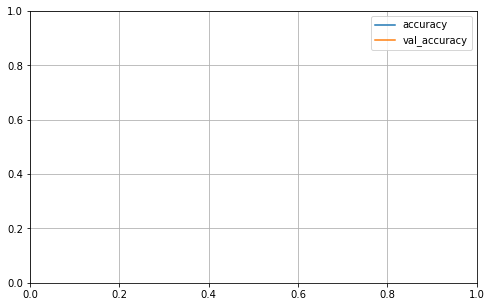

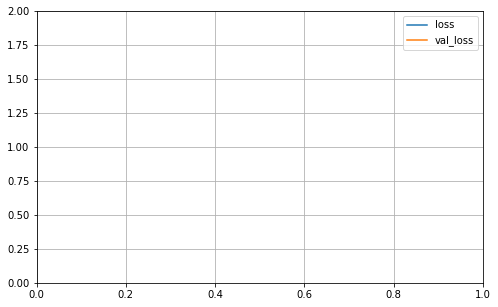

In [8]:
def plot_learning_curves(history, label, epcohs, min_value, max_value):
    data = {}
    data[label] = history.history[label]
    data['val_'+label] = history.history['val_'+label]
    pd.DataFrame(data).plot(figsize=(8, 5))
    plt.grid(True)
    plt.axis([0, epochs, min_value, max_value])
    plt.show()
    
plot_learning_curves(history, 'accuracy', epochs, 0, 1)
plot_learning_curves(history, 'loss', epochs, 0, 2)

In [9]:
test_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255)
test_generator = valid_datagen.flow_from_dataframe(
    test_df,
    directory = "D:/project/dataset/cifar10/output/",
    x_col = 'filepath',
    y_col = 'class',
    classes = class_names,
    target_size = (height, width),
    batch_size = batch_size,
    seed = 7,
    shuffle = False,
    class_mode = "sparse")
test_num = test_generator.samples
print(test_num)

Found 300000 validated image filenames belonging to 10 classes.
300000


In [ ]:
import dill


class Obj:
    def __init__(self, info):
        self.info = info


obj = Obj("this is a local object")

pk = dill.dumps(obj)
new_obj = dill.loads(pk)

test_predict = model.predict_generator(test_generator,
                                       workers = 10,
                                       use_multiprocessing = True)

Instructions for updating:
Please use Model.predict, which supports generators.


Exception in thread Thread-6:
Traceback (most recent call last):
  File "D:\software\anaconda\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "D:\software\anaconda\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "D:\software\anaconda\lib\site-packages\tensorflow\python\keras\utils\data_utils.py", line 860, in _run
    with closing(self.executor_fn(_SHARED_SEQUENCES)) as executor:
  File "D:\software\anaconda\lib\site-packages\tensorflow\python\keras\utils\data_utils.py", line 837, in pool_fn
    pool = get_pool_class(True)(
  File "D:\software\anaconda\lib\multiprocessing\context.py", line 119, in Pool
    return Pool(processes, initializer, initargs, maxtasksperchild,
  File "D:\software\anaconda\lib\multiprocessing\pool.py", line 212, in __init__
    self._repopulate_pool()
  File "D:\software\anaconda\lib\multiprocessing\pool.py", line 303, in _repopulate_pool
    return self._repopulate_pool_static(self._ctx, self.Proc

In [ ]:
print(test_predict.shape)

In [ ]:
print(test_predict[0:5])

In [ ]:
test_predict_class_indices = np.argmax(test_predict, axis = 1)

In [ ]:
print(test_predict_class_indices[0:5])

In [ ]:
test_predict_class = [class_names[index] 
                      for index in test_predict_class_indices]

In [ ]:
print(test_predict_class[0:5])

In [ ]:
def generate_submissions(filename, predict_class):
    with open(filename, 'w') as f:
        f.write('id,label\n')
        for i in range(len(predict_class)):
            f.write('%d,%s\n' % (i+1, predict_class[i]))

output_file = "D:/project/dataset/cifar10/submission.csv"
generate_submissions(output_file, test_predict_class)